<a href="https://colab.research.google.com/github/cincysam6/CMSAC_2024/blob/main/Target_Probability_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyarrow scikit-learn xgboost pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import optuna
import re as re
warnings.filterwarnings('ignore')

In [ ]:
# Read the parquet file
target_df = pd.read_parquet('/content/drive/MyDrive/CMSAC_2024/target_comp_model_df.parquet')


In [ ]:
### Set Display Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [ ]:
print(target_df.columns.tolist())

['gameId', 'playId', 'nflId', 'frameId', 'pff_role', 'x', 'y', 'dir', 's', 'o', 'a', 'coverage_nflId_1', 'coverage_nflId_2', 'coverage_nflId_3', 'coverage_pff_role_1', 'coverage_pff_role_2', 'coverage_pff_role_3', 'coverage_x_1', 'coverage_x_2', 'coverage_x_3', 'coverage_y_1', 'coverage_y_2', 'coverage_y_3', 'coverage_s_1', 'coverage_s_2', 'coverage_s_3', 'coverage_a_1', 'coverage_a_2', 'coverage_a_3', 'coverage_o_1', 'coverage_o_2', 'coverage_o_3', 'coverage_dir_1', 'coverage_dir_2', 'coverage_dir_3', 'rec_cov_dist_1', 'rec_cov_dist_2', 'rec_cov_dist_3', 'yardlineNumber', 'absoluteYardlineNumber', 'ball_nflId', 'ball_event', 'ball_pff_role', 'ball_x', 'ball_y', 'ball_dir', 'ball_s', 'ball_o', 'ball_a', 'qb_nflId', 'qb_pff_role', 'qb_x', 'qb_y', 'qb_dir', 'qb_s', 'qb_o', 'qb_a', 'is_target', 'down', 'yardsToGo', 'defendersInBox', 'los', 'pff_passCoverageType', 'incomplete_pass', 'week', 'dist_from_los', 'dist_from_qb', 'dist_from_ball', 'dist_from_side', 'pff_passCoverageTypeMan', 'pff

In [ ]:
cols_to_remove =['pff_role',
                 'coverage_nflId_1',
                 'coverage_nflId_2',
                 'coverage_nflId_3',
                 'coverage_pff_role_1',
                 'coverage_pff_role_2',
                 'coverage_pff_role_3',
                 'yardlineNumber',
                 'absoluteYardlineNumber',
                 'ball_event',
                 'ball_nflId',
                 'ball_pff_role',
                 'ball_dir',
                 'ball_s',
                 'ball_a',
                 'ball_x',
                 'ball_y',
                 'ball_o',
                 'qb_nflId',
                 'qb_pff_role',
                 'los',
                 'pff_passCoverageType',
                 'incomplete_pass'
                 ]

In [ ]:
model_df = target_df.drop(columns=cols_to_remove)

In [ ]:
model_df.head().T

,0,1,2,3,4
gameId,2.021091e+09,2.021091e+09,2.021091e+09,2.021091e+09,2.021091e+09
playId,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01,9.700000e+01
nflId,3.548100e+04,3.563400e+04,3.998500e+04,4.123300e+04,4.489600e+04
frameId,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
x,4.108000e+01,4.099000e+01,3.754000e+01,4.201000e+01,4.009000e+01
y,2.915000e+01,3.674000e+01,2.226000e+01,1.619000e+01,3.672000e+01
dir,2.387700e+02,3.256900e+02,1.322800e+02,2.322500e+02,1.832700e+02
s,3.100000e-01,0.000000e+00,1.100000e-01,0.000000e+00,3.540000e+00
o,3.596000e+01,1.137500e+02,9.178000e+01,1.312000e+02,6.772000e+01
a,4.300000e-01,0.000000e+00,7.000000e-02,0.000000e+00,1.470000e+00


In [ ]:
model_df = model_df.dropna()

In [ ]:
model_df['game_play_id'] = model_df['gameId'].astype(str) + "_" + model_df['playId'].astype(str)

In [ ]:
model_df.isnull().sum()

,0
gameId,0
playId,0
nflId,0
frameId,0
x,0
y,0
dir,0
s,0
o,0
a,0


In [ ]:
# Split the data
test = model_df[model_df['week'] > 6].copy()

train = model_df[model_df['week'] <= 6].copy()


# Columns to remove
cols_to_remove = ["is_target", "gameId",'playId', "week", "frameId","nflId"]

In [ ]:
# Prepare training and test data
train_data = train.drop(cols_to_remove, axis=1)
train_labels = train['is_target']

test_data = test.drop(cols_to_remove, axis=1)
test_labels = test['is_target']

In [ ]:
X_train = train_data.drop(columns=['game_play_id'])
y_train = train_labels

In [ ]:
X_train_cols = X_train.columns.tolist()

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import average_precision_score
def objective(trial):

    # Define the XGBoost parameters with adjusted ranges to mitigate overfitting
    param = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  # Precision-Recall AUC

        # Adjusting ranges for regularization
        'lambda': trial.suggest_loguniform('lambda', 1, 100.0),  # Increased upper bound for stronger regularization
        'alpha': trial.suggest_loguniform('alpha', 1, 100.0),    # Increased upper bound for stronger regularization

        # Reduce learning rate and increase `num_boost_round` to allow the model to learn more gradually
        'eta': trial.suggest_loguniform('eta', 0.001, 0.05),  # Lower learning rate for more gradual learning

        # Regularization parameter gamma to control complexity
        'gamma': trial.suggest_float('gamma', 1.0, 10.0),  # Increased minimum for stronger regularization

        # Adjust subsample and colsample_bytree to introduce randomness
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),  # Larger lower bound to ensure sufficient sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),  # Larger lower bound for more features per tree

        # Max depth and min child weight to control the complexity of trees
        'max_depth': trial.suggest_int('max_depth', 3, 8),  # Reduced maximum depth to limit tree complexity
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),  # Increased lower bound to control the number of instances in each node
        'tree_method': "hist",
        'device': "cuda",
        'predictor': 'gpu_predictor'
    }

    # Assuming train_data and train_labels are pre-defined
    X_train = train_data.drop(columns=['game_play_id'])  # Drop the 'game_play_id' column
    y_train = train_labels
    groups = train_data['game_play_id']  # Group by 'game_play_id'

    # 5-Fold Cross Validation grouped by 'game_play_id'
    kf = GroupKFold(n_splits=5)
    pr_auc_list = []

    for train_index, test_index in kf.split(X_train, y_train, groups=groups):
        X_train_k, X_val_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[test_index]

        # Ensure no leakage by performing feature engineering within the CV loop

        # Example: Standardization within each fold (uncomment if needed)
        # scaler = StandardScaler()
        # X_train_k = scaler.fit_transform(X_train_k)
        # X_val_k = scaler.transform(X_val_k)

        dtrain_k = xgb.DMatrix(X_train_k, label=y_train_k)
        dval_k = xgb.DMatrix(X_val_k, label=y_val_k)

        # Train the model with early stopping
        bst = xgb.train(param, dtrain_k, num_boost_round=2500, evals=[(dval_k, "validation")], early_stopping_rounds=100, verbose_eval=50)
        preds = bst.predict(dval_k)

        # Calculate PR AUC
        pr_auc = average_precision_score(y_val_k, preds)
        pr_auc_list.append(pr_auc)

    # Average PR AUC over all folds
    avg_pr_auc = np.mean(pr_auc_list)

    return avg_pr_auc

In [ ]:

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')  # We want to maximize the PR AUC

# Optimize the objective function using the study
study.optimize(objective, n_trials=25)  # You can adjust n_trials based on how thorough you want the search to be

# Retrieve the best trial
best_trial = study.best_trial
best_params = best_trial.params

# Output the results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', best_params)
print('Best trial value (PR AUC):', best_trial.value)

[I 2024-08-25 03:06:59,661] A new study created in memory with name: no-name-0f1b9b5b-59ba-448e-bfa4-bb58e66a2a66


[0]	validation-aucpr:0.24605
[50]	validation-aucpr:0.28597
[100]	validation-aucpr:0.30052
[150]	validation-aucpr:0.31501
[200]	validation-aucpr:0.32404
[250]	validation-aucpr:0.33476
[300]	validation-aucpr:0.34013
[350]	validation-aucpr:0.34396
[400]	validation-aucpr:0.34747
[450]	validation-aucpr:0.35076
[500]	validation-aucpr:0.35309
[550]	validation-aucpr:0.35486
[600]	validation-aucpr:0.35683
[650]	validation-aucpr:0.35811
[700]	validation-aucpr:0.35893
[750]	validation-aucpr:0.35994
[800]	validation-aucpr:0.36103
[850]	validation-aucpr:0.36198
[900]	validation-aucpr:0.36218
[950]	validation-aucpr:0.36279
[1000]	validation-aucpr:0.36312
[1050]	validation-aucpr:0.36346
[1100]	validation-aucpr:0.36376
[1150]	validation-aucpr:0.36401
[1200]	validation-aucpr:0.36415
[1250]	validation-aucpr:0.36418
[1300]	validation-aucpr:0.36426
[1350]	validation-aucpr:0.36433
[1400]	validation-aucpr:0.36441
[1450]	validation-aucpr:0.36447
[1500]	validation-aucpr:0.36451
[1550]	validation-aucpr:0.36452

[I 2024-08-25 03:35:13,802] Trial 0 finished with value: 0.35596369310991677 and parameters: {'lambda': 7.427615360270696, 'alpha': 67.0153448750443, 'eta': 0.031112314178131296, 'gamma': 6.599251967917087, 'subsample': 0.8498323057628787, 'colsample_bytree': 0.8564341099999655, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 0 with value: 0.35596369310991677.


[0]	validation-aucpr:0.22066
[50]	validation-aucpr:0.31461
[100]	validation-aucpr:0.33903
[150]	validation-aucpr:0.35228
[200]	validation-aucpr:0.35957
[250]	validation-aucpr:0.36441
[300]	validation-aucpr:0.36722
[350]	validation-aucpr:0.36919
[400]	validation-aucpr:0.36963
[450]	validation-aucpr:0.37024
[500]	validation-aucpr:0.37018
[550]	validation-aucpr:0.37041
[600]	validation-aucpr:0.37103
[650]	validation-aucpr:0.37104
[700]	validation-aucpr:0.37112
[708]	validation-aucpr:0.37120
[0]	validation-aucpr:0.21681
[50]	validation-aucpr:0.31437
[100]	validation-aucpr:0.33580
[150]	validation-aucpr:0.35171
[200]	validation-aucpr:0.35955
[250]	validation-aucpr:0.36451
[300]	validation-aucpr:0.36727
[350]	validation-aucpr:0.36768
[400]	validation-aucpr:0.36919
[450]	validation-aucpr:0.36967
[500]	validation-aucpr:0.36987
[550]	validation-aucpr:0.36979
[561]	validation-aucpr:0.36987
[0]	validation-aucpr:0.21672
[50]	validation-aucpr:0.30045
[100]	validation-aucpr:0.32241
[150]	validation-

[I 2024-08-25 03:51:18,825] Trial 1 finished with value: 0.3642697531717693 and parameters: {'lambda': 42.43264265897789, 'alpha': 54.01532547100206, 'eta': 0.04376364361995092, 'gamma': 6.854363578371194, 'subsample': 0.519102216318074, 'colsample_bytree': 0.6066639983819552, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 1 with value: 0.3642697531717693.


[0]	validation-aucpr:0.21325
[50]	validation-aucpr:0.30293
[100]	validation-aucpr:0.31592
[150]	validation-aucpr:0.32692
[200]	validation-aucpr:0.33530
[250]	validation-aucpr:0.34412
[300]	validation-aucpr:0.34888
[350]	validation-aucpr:0.35291
[400]	validation-aucpr:0.35659
[450]	validation-aucpr:0.35869
[500]	validation-aucpr:0.36038
[550]	validation-aucpr:0.36178
[600]	validation-aucpr:0.36342
[650]	validation-aucpr:0.36469
[700]	validation-aucpr:0.36567
[750]	validation-aucpr:0.36595
[800]	validation-aucpr:0.36650
[850]	validation-aucpr:0.36683
[900]	validation-aucpr:0.36700
[950]	validation-aucpr:0.36755
[1000]	validation-aucpr:0.36752
[1050]	validation-aucpr:0.36732
[1087]	validation-aucpr:0.36724
[0]	validation-aucpr:0.21128
[50]	validation-aucpr:0.29902
[100]	validation-aucpr:0.31047
[150]	validation-aucpr:0.32539
[200]	validation-aucpr:0.33675
[250]	validation-aucpr:0.34418
[300]	validation-aucpr:0.35011
[350]	validation-aucpr:0.35315
[400]	validation-aucpr:0.35648
[450]	valid

[I 2024-08-25 04:18:50,620] Trial 2 finished with value: 0.3625350319978697 and parameters: {'lambda': 3.257493572152728, 'alpha': 5.396491923759711, 'eta': 0.029357915125941398, 'gamma': 5.844878859293351, 'subsample': 0.8311139692413692, 'colsample_bytree': 0.5726741057779392, 'max_depth': 6, 'min_child_weight': 10}. Best is trial 1 with value: 0.3642697531717693.


[0]	validation-aucpr:0.22116
[50]	validation-aucpr:0.29699
[100]	validation-aucpr:0.30203
[150]	validation-aucpr:0.30526
[200]	validation-aucpr:0.30828
[250]	validation-aucpr:0.31128
[300]	validation-aucpr:0.31398
[350]	validation-aucpr:0.31636
[400]	validation-aucpr:0.31928
[450]	validation-aucpr:0.32167
[500]	validation-aucpr:0.32368
[550]	validation-aucpr:0.32589
[600]	validation-aucpr:0.32805
[650]	validation-aucpr:0.33041
[700]	validation-aucpr:0.33261
[750]	validation-aucpr:0.33474
[800]	validation-aucpr:0.33742
[850]	validation-aucpr:0.33988
[900]	validation-aucpr:0.34190
[950]	validation-aucpr:0.34371
[1000]	validation-aucpr:0.34564
[1050]	validation-aucpr:0.34761
[1100]	validation-aucpr:0.34935
[1150]	validation-aucpr:0.35094
[1200]	validation-aucpr:0.35260
[1250]	validation-aucpr:0.35409
[1300]	validation-aucpr:0.35544
[1350]	validation-aucpr:0.35663
[1400]	validation-aucpr:0.35771
[1450]	validation-aucpr:0.35865
[1500]	validation-aucpr:0.35951
[1550]	validation-aucpr:0.36027

[I 2024-08-25 05:21:13,605] Trial 3 finished with value: 0.36162112697186666 and parameters: {'lambda': 5.624104412569308, 'alpha': 15.149843708894991, 'eta': 0.004842696850499834, 'gamma': 5.563186039004307, 'subsample': 0.5735388661169609, 'colsample_bytree': 0.6770522479022628, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 1 with value: 0.3642697531717693.


[0]	validation-aucpr:0.24359
[50]	validation-aucpr:0.28375
[100]	validation-aucpr:0.29331
[150]	validation-aucpr:0.30193
[200]	validation-aucpr:0.31263
[250]	validation-aucpr:0.32156
[300]	validation-aucpr:0.32838
[350]	validation-aucpr:0.33398
[400]	validation-aucpr:0.33844
[450]	validation-aucpr:0.34165
[500]	validation-aucpr:0.34458
[550]	validation-aucpr:0.34656
[600]	validation-aucpr:0.34853
[650]	validation-aucpr:0.35000
[700]	validation-aucpr:0.35168
[750]	validation-aucpr:0.35321
[800]	validation-aucpr:0.35457
[850]	validation-aucpr:0.35565
[900]	validation-aucpr:0.35652
[950]	validation-aucpr:0.35782
[1000]	validation-aucpr:0.35891
[1050]	validation-aucpr:0.36007
[1100]	validation-aucpr:0.36067
[1150]	validation-aucpr:0.36133
[1200]	validation-aucpr:0.36183
[1250]	validation-aucpr:0.36233
[1300]	validation-aucpr:0.36289
[1350]	validation-aucpr:0.36338
[1400]	validation-aucpr:0.36363
[1450]	validation-aucpr:0.36404
[1500]	validation-aucpr:0.36435
[1550]	validation-aucpr:0.36455

[I 2024-08-25 06:08:12,041] Trial 4 finished with value: 0.3601417323875119 and parameters: {'lambda': 23.803762616550163, 'alpha': 7.275159891286426, 'eta': 0.02106800737385281, 'gamma': 4.270630263909402, 'subsample': 0.7887243673711892, 'colsample_bytree': 0.7509799554848223, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 1 with value: 0.3642697531717693.


[0]	validation-aucpr:0.24295
[50]	validation-aucpr:0.27696
[100]	validation-aucpr:0.28364
[150]	validation-aucpr:0.28969
[200]	validation-aucpr:0.29505
[250]	validation-aucpr:0.30012
[300]	validation-aucpr:0.30535
[350]	validation-aucpr:0.31100
[400]	validation-aucpr:0.31608
[450]	validation-aucpr:0.32075
[500]	validation-aucpr:0.32501
[550]	validation-aucpr:0.32870
[600]	validation-aucpr:0.33213
[650]	validation-aucpr:0.33505
[700]	validation-aucpr:0.33743
[750]	validation-aucpr:0.33994
[800]	validation-aucpr:0.34174
[850]	validation-aucpr:0.34346
[900]	validation-aucpr:0.34537
[950]	validation-aucpr:0.34707
[1000]	validation-aucpr:0.34847
[1050]	validation-aucpr:0.34976
[1100]	validation-aucpr:0.35079
[1150]	validation-aucpr:0.35200
[1200]	validation-aucpr:0.35314
[1250]	validation-aucpr:0.35390
[1300]	validation-aucpr:0.35468
[1350]	validation-aucpr:0.35556
[1400]	validation-aucpr:0.35614
[1450]	validation-aucpr:0.35674
[1500]	validation-aucpr:0.35739
[1550]	validation-aucpr:0.35805

[I 2024-08-25 06:55:33,586] Trial 5 finished with value: 0.354638202811466 and parameters: {'lambda': 5.300939379608716, 'alpha': 88.98263329563224, 'eta': 0.012563354693927758, 'gamma': 6.54041784654382, 'subsample': 0.6488727889160851, 'colsample_bytree': 0.8295934177782485, 'max_depth': 5, 'min_child_weight': 15}. Best is trial 1 with value: 0.3642697531717693.


[0]	validation-aucpr:0.25866
[50]	validation-aucpr:0.31061
[100]	validation-aucpr:0.32623
[150]	validation-aucpr:0.34051
[200]	validation-aucpr:0.35060
[250]	validation-aucpr:0.35828
[300]	validation-aucpr:0.36242
[350]	validation-aucpr:0.36640
[400]	validation-aucpr:0.36868
[450]	validation-aucpr:0.37102
[500]	validation-aucpr:0.37267
[550]	validation-aucpr:0.37367
[600]	validation-aucpr:0.37397
[650]	validation-aucpr:0.37434
[700]	validation-aucpr:0.37449
[750]	validation-aucpr:0.37438
[800]	validation-aucpr:0.37447
[816]	validation-aucpr:0.37445
[0]	validation-aucpr:0.25408
[50]	validation-aucpr:0.30966
[100]	validation-aucpr:0.32362
[150]	validation-aucpr:0.33772
[200]	validation-aucpr:0.35027
[250]	validation-aucpr:0.35683
[300]	validation-aucpr:0.36075
[350]	validation-aucpr:0.36488
[400]	validation-aucpr:0.36780
[450]	validation-aucpr:0.36928
[500]	validation-aucpr:0.37028
[550]	validation-aucpr:0.37155
[600]	validation-aucpr:0.37278
[650]	validation-aucpr:0.37302
[700]	validati

[I 2024-08-25 07:21:26,747] Trial 6 finished with value: 0.36635193193727805 and parameters: {'lambda': 1.654360140345678, 'alpha': 47.82026107031764, 'eta': 0.02452238664087176, 'gamma': 7.446042428562989, 'subsample': 0.8547152758120886, 'colsample_bytree': 0.824247558687021, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.22971
[50]	validation-aucpr:0.27312
[100]	validation-aucpr:0.29002
[150]	validation-aucpr:0.30623
[200]	validation-aucpr:0.31532
[250]	validation-aucpr:0.32298
[300]	validation-aucpr:0.32746
[350]	validation-aucpr:0.33068
[400]	validation-aucpr:0.33453
[450]	validation-aucpr:0.33772
[500]	validation-aucpr:0.34057
[550]	validation-aucpr:0.34267
[600]	validation-aucpr:0.34506
[650]	validation-aucpr:0.34716
[700]	validation-aucpr:0.34875
[750]	validation-aucpr:0.35031
[800]	validation-aucpr:0.35173
[850]	validation-aucpr:0.35289
[900]	validation-aucpr:0.35342
[950]	validation-aucpr:0.35443
[1000]	validation-aucpr:0.35515
[1050]	validation-aucpr:0.35597
[1100]	validation-aucpr:0.35632
[1150]	validation-aucpr:0.35658
[1200]	validation-aucpr:0.35707
[1250]	validation-aucpr:0.35722
[1300]	validation-aucpr:0.35730
[1350]	validation-aucpr:0.35754
[1400]	validation-aucpr:0.35778
[1450]	validation-aucpr:0.35808
[1500]	validation-aucpr:0.35818
[1550]	validation-aucpr:0.35822

[I 2024-08-25 07:50:05,718] Trial 7 finished with value: 0.35055777421114265 and parameters: {'lambda': 3.777339162979863, 'alpha': 12.71194336581489, 'eta': 0.03451939398740759, 'gamma': 9.32143410017177, 'subsample': 0.7146242152619771, 'colsample_bytree': 0.8005771355360223, 'max_depth': 4, 'min_child_weight': 17}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.21192
[50]	validation-aucpr:0.27661
[100]	validation-aucpr:0.28165
[150]	validation-aucpr:0.28303
[200]	validation-aucpr:0.28517
[250]	validation-aucpr:0.28751
[300]	validation-aucpr:0.28932
[350]	validation-aucpr:0.29137
[400]	validation-aucpr:0.29350
[450]	validation-aucpr:0.29576
[500]	validation-aucpr:0.29759
[550]	validation-aucpr:0.29995
[600]	validation-aucpr:0.30187
[650]	validation-aucpr:0.30341
[700]	validation-aucpr:0.30589
[750]	validation-aucpr:0.30804
[800]	validation-aucpr:0.30961
[850]	validation-aucpr:0.31178
[900]	validation-aucpr:0.31368
[950]	validation-aucpr:0.31597
[1000]	validation-aucpr:0.31754
[1050]	validation-aucpr:0.31899
[1100]	validation-aucpr:0.32091
[1150]	validation-aucpr:0.32239
[1200]	validation-aucpr:0.32387
[1250]	validation-aucpr:0.32565
[1300]	validation-aucpr:0.32706
[1350]	validation-aucpr:0.32873
[1400]	validation-aucpr:0.33057
[1450]	validation-aucpr:0.33162
[1500]	validation-aucpr:0.33263
[1550]	validation-aucpr:0.33384

[I 2024-08-25 08:41:05,566] Trial 8 finished with value: 0.3397328371647267 and parameters: {'lambda': 6.2242752471228995, 'alpha': 20.762455039041317, 'eta': 0.004843913889338253, 'gamma': 3.8865586141119124, 'subsample': 0.5543631064677538, 'colsample_bytree': 0.6546975159854791, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.22117
[50]	validation-aucpr:0.30627
[100]	validation-aucpr:0.32619
[150]	validation-aucpr:0.34019
[200]	validation-aucpr:0.34903
[250]	validation-aucpr:0.35607
[300]	validation-aucpr:0.36059
[350]	validation-aucpr:0.36435
[400]	validation-aucpr:0.36684
[450]	validation-aucpr:0.36853
[500]	validation-aucpr:0.36943
[550]	validation-aucpr:0.36974
[600]	validation-aucpr:0.36978
[650]	validation-aucpr:0.36989
[700]	validation-aucpr:0.37007
[750]	validation-aucpr:0.37012
[800]	validation-aucpr:0.37012
[826]	validation-aucpr:0.37008
[0]	validation-aucpr:0.21791
[50]	validation-aucpr:0.30612
[100]	validation-aucpr:0.32278
[150]	validation-aucpr:0.33989
[200]	validation-aucpr:0.34994
[250]	validation-aucpr:0.35662
[300]	validation-aucpr:0.36110
[350]	validation-aucpr:0.36414
[400]	validation-aucpr:0.36682
[450]	validation-aucpr:0.36801
[500]	validation-aucpr:0.36837
[550]	validation-aucpr:0.36882
[600]	validation-aucpr:0.36895
[650]	validation-aucpr:0.36912
[700]	validati

[I 2024-08-25 08:59:46,884] Trial 9 finished with value: 0.36206096826213957 and parameters: {'lambda': 14.029130952083054, 'alpha': 65.33583766300238, 'eta': 0.03398153606164896, 'gamma': 8.492696195678946, 'subsample': 0.8575723393811913, 'colsample_bytree': 0.6275126214467424, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.26507
[50]	validation-aucpr:0.29446
[100]	validation-aucpr:0.29649
[150]	validation-aucpr:0.29758
[200]	validation-aucpr:0.29830
[250]	validation-aucpr:0.29964
[300]	validation-aucpr:0.30081
[350]	validation-aucpr:0.30114
[400]	validation-aucpr:0.30240
[450]	validation-aucpr:0.30338
[500]	validation-aucpr:0.30475
[550]	validation-aucpr:0.30580
[600]	validation-aucpr:0.30691
[650]	validation-aucpr:0.30786
[700]	validation-aucpr:0.30922
[750]	validation-aucpr:0.31025
[800]	validation-aucpr:0.31134
[850]	validation-aucpr:0.31289
[900]	validation-aucpr:0.31404
[950]	validation-aucpr:0.31503
[1000]	validation-aucpr:0.31598
[1050]	validation-aucpr:0.31685
[1100]	validation-aucpr:0.31784
[1150]	validation-aucpr:0.31863
[1200]	validation-aucpr:0.31952
[1250]	validation-aucpr:0.32023
[1300]	validation-aucpr:0.32093
[1350]	validation-aucpr:0.32168
[1400]	validation-aucpr:0.32241
[1450]	validation-aucpr:0.32322
[1500]	validation-aucpr:0.32397
[1550]	validation-aucpr:0.32465

[I 2024-08-25 10:14:36,920] Trial 10 finished with value: 0.327856109354295 and parameters: {'lambda': 1.0830229123140367, 'alpha': 1.2170794894327155, 'eta': 0.0011237995424208727, 'gamma': 1.0567714785671942, 'subsample': 0.8993995207155112, 'colsample_bytree': 0.8985444016759593, 'max_depth': 8, 'min_child_weight': 19}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.21204
[50]	validation-aucpr:0.30004
[100]	validation-aucpr:0.31245
[150]	validation-aucpr:0.31789
[200]	validation-aucpr:0.32216
[250]	validation-aucpr:0.32871
[300]	validation-aucpr:0.33454
[350]	validation-aucpr:0.33876
[400]	validation-aucpr:0.34345
[450]	validation-aucpr:0.34691
[500]	validation-aucpr:0.34983
[550]	validation-aucpr:0.35288
[600]	validation-aucpr:0.35554
[650]	validation-aucpr:0.35736
[700]	validation-aucpr:0.35919
[750]	validation-aucpr:0.36042
[800]	validation-aucpr:0.36207
[850]	validation-aucpr:0.36328
[900]	validation-aucpr:0.36458
[950]	validation-aucpr:0.36602
[1000]	validation-aucpr:0.36696
[1050]	validation-aucpr:0.36778
[1100]	validation-aucpr:0.36843
[1150]	validation-aucpr:0.36905
[1200]	validation-aucpr:0.36954
[1250]	validation-aucpr:0.37004
[1300]	validation-aucpr:0.37047
[1350]	validation-aucpr:0.37066
[1400]	validation-aucpr:0.37100
[1450]	validation-aucpr:0.37109
[1500]	validation-aucpr:0.37125
[1550]	validation-aucpr:0.37142

[I 2024-08-25 11:07:52,427] Trial 11 finished with value: 0.365215777893163 and parameters: {'lambda': 67.80553088129932, 'alpha': 43.89489095531306, 'eta': 0.012240257846180816, 'gamma': 7.676094806385111, 'subsample': 0.5099360884936733, 'colsample_bytree': 0.5062901295306083, 'max_depth': 8, 'min_child_weight': 14}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.21519
[50]	validation-aucpr:0.29968
[100]	validation-aucpr:0.30771
[150]	validation-aucpr:0.31341
[200]	validation-aucpr:0.31655
[250]	validation-aucpr:0.32101
[300]	validation-aucpr:0.32583
[350]	validation-aucpr:0.33001
[400]	validation-aucpr:0.33407
[450]	validation-aucpr:0.33741
[500]	validation-aucpr:0.34129
[550]	validation-aucpr:0.34394
[600]	validation-aucpr:0.34717
[650]	validation-aucpr:0.34961
[700]	validation-aucpr:0.35182
[750]	validation-aucpr:0.35378
[800]	validation-aucpr:0.35555
[850]	validation-aucpr:0.35686
[900]	validation-aucpr:0.35828
[950]	validation-aucpr:0.36006
[1000]	validation-aucpr:0.36129
[1050]	validation-aucpr:0.36230
[1100]	validation-aucpr:0.36316
[1150]	validation-aucpr:0.36388
[1200]	validation-aucpr:0.36486
[1250]	validation-aucpr:0.36554
[1300]	validation-aucpr:0.36612
[1350]	validation-aucpr:0.36667
[1400]	validation-aucpr:0.36729
[1450]	validation-aucpr:0.36775
[1500]	validation-aucpr:0.36827
[1550]	validation-aucpr:0.36875

[I 2024-08-25 12:01:27,951] Trial 12 finished with value: 0.3645062858114077 and parameters: {'lambda': 92.90065739363823, 'alpha': 28.878485139715988, 'eta': 0.01068331287614653, 'gamma': 8.197402748355529, 'subsample': 0.7263132104063441, 'colsample_bytree': 0.5210475536688878, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.21699
[50]	validation-aucpr:0.25010
[100]	validation-aucpr:0.25523
[150]	validation-aucpr:0.26249
[200]	validation-aucpr:0.26974
[250]	validation-aucpr:0.27528
[300]	validation-aucpr:0.27943
[350]	validation-aucpr:0.28406
[400]	validation-aucpr:0.28775
[450]	validation-aucpr:0.29123
[500]	validation-aucpr:0.29426
[550]	validation-aucpr:0.29673
[600]	validation-aucpr:0.29892
[650]	validation-aucpr:0.30083
[700]	validation-aucpr:0.30308
[750]	validation-aucpr:0.30527
[800]	validation-aucpr:0.30740
[850]	validation-aucpr:0.30914
[900]	validation-aucpr:0.31068
[950]	validation-aucpr:0.31224
[1000]	validation-aucpr:0.31362
[1050]	validation-aucpr:0.31498
[1100]	validation-aucpr:0.31634
[1150]	validation-aucpr:0.31740
[1200]	validation-aucpr:0.31858
[1250]	validation-aucpr:0.32002
[1300]	validation-aucpr:0.32117
[1350]	validation-aucpr:0.32236
[1400]	validation-aucpr:0.32366
[1450]	validation-aucpr:0.32452
[1500]	validation-aucpr:0.32543
[1550]	validation-aucpr:0.32644

[I 2024-08-25 12:40:48,139] Trial 13 finished with value: 0.33114678690260907 and parameters: {'lambda': 1.3067853543376633, 'alpha': 32.90099135537062, 'eta': 0.014806110902726311, 'gamma': 9.807647896435503, 'subsample': 0.6458272081968737, 'colsample_bytree': 0.7426489179172896, 'max_depth': 3, 'min_child_weight': 10}. Best is trial 6 with value: 0.36635193193727805.


[0]	validation-aucpr:0.21989
[50]	validation-aucpr:0.30889
[100]	validation-aucpr:0.31784
[150]	validation-aucpr:0.32298
[200]	validation-aucpr:0.32586
[250]	validation-aucpr:0.33002
[300]	validation-aucpr:0.33442
[350]	validation-aucpr:0.33772
[400]	validation-aucpr:0.34206
[450]	validation-aucpr:0.34492
[500]	validation-aucpr:0.34771
[550]	validation-aucpr:0.35009
[600]	validation-aucpr:0.35262
[650]	validation-aucpr:0.35480
[700]	validation-aucpr:0.35714
[750]	validation-aucpr:0.35901
[800]	validation-aucpr:0.36093
[850]	validation-aucpr:0.36212
[900]	validation-aucpr:0.36359
[950]	validation-aucpr:0.36514
[1000]	validation-aucpr:0.36624
[1050]	validation-aucpr:0.36734
[1100]	validation-aucpr:0.36830
[1150]	validation-aucpr:0.36907
[1200]	validation-aucpr:0.36989
[1250]	validation-aucpr:0.37073
[1300]	validation-aucpr:0.37098
[1350]	validation-aucpr:0.37151
[1400]	validation-aucpr:0.37230
[1450]	validation-aucpr:0.37281
[1500]	validation-aucpr:0.37337
[1550]	validation-aucpr:0.37367

[I 2024-08-25 13:40:24,472] Trial 14 finished with value: 0.3685987561879419 and parameters: {'lambda': 78.93291604690498, 'alpha': 3.510094597348211, 'eta': 0.008621586914499579, 'gamma': 8.035957236253163, 'subsample': 0.7591862404858662, 'colsample_bytree': 0.5158581984462384, 'max_depth': 8, 'min_child_weight': 13}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.25110
[50]	validation-aucpr:0.29578
[100]	validation-aucpr:0.30002
[150]	validation-aucpr:0.30118
[200]	validation-aucpr:0.30250
[250]	validation-aucpr:0.30479
[300]	validation-aucpr:0.30701
[350]	validation-aucpr:0.30891
[400]	validation-aucpr:0.31085
[450]	validation-aucpr:0.31234
[500]	validation-aucpr:0.31377
[550]	validation-aucpr:0.31546
[600]	validation-aucpr:0.31703
[650]	validation-aucpr:0.31826
[700]	validation-aucpr:0.31953
[750]	validation-aucpr:0.32092
[800]	validation-aucpr:0.32226
[850]	validation-aucpr:0.32379
[900]	validation-aucpr:0.32532
[950]	validation-aucpr:0.32683
[1000]	validation-aucpr:0.32821
[1050]	validation-aucpr:0.32970
[1100]	validation-aucpr:0.33107
[1150]	validation-aucpr:0.33271
[1200]	validation-aucpr:0.33398
[1250]	validation-aucpr:0.33551
[1300]	validation-aucpr:0.33702
[1350]	validation-aucpr:0.33838
[1400]	validation-aucpr:0.33979
[1450]	validation-aucpr:0.34118
[1500]	validation-aucpr:0.34222
[1550]	validation-aucpr:0.34342

[I 2024-08-25 14:41:00,099] Trial 15 finished with value: 0.3504525230002394 and parameters: {'lambda': 2.07130628720474, 'alpha': 2.4194662713276625, 'eta': 0.0029004498559715855, 'gamma': 4.4197561615209935, 'subsample': 0.7656490818108223, 'colsample_bytree': 0.7351546972937673, 'max_depth': 7, 'min_child_weight': 12}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.21309
[50]	validation-aucpr:0.28951
[100]	validation-aucpr:0.29845
[150]	validation-aucpr:0.30225
[200]	validation-aucpr:0.30483
[250]	validation-aucpr:0.30764
[300]	validation-aucpr:0.31102
[350]	validation-aucpr:0.31343
[400]	validation-aucpr:0.31618
[450]	validation-aucpr:0.31866
[500]	validation-aucpr:0.32102
[550]	validation-aucpr:0.32398
[600]	validation-aucpr:0.32648
[650]	validation-aucpr:0.32859
[700]	validation-aucpr:0.33159
[750]	validation-aucpr:0.33429
[800]	validation-aucpr:0.33746
[850]	validation-aucpr:0.33936
[900]	validation-aucpr:0.34128
[950]	validation-aucpr:0.34343
[1000]	validation-aucpr:0.34536
[1050]	validation-aucpr:0.34726
[1100]	validation-aucpr:0.34855
[1150]	validation-aucpr:0.34954
[1200]	validation-aucpr:0.35075
[1250]	validation-aucpr:0.35175
[1300]	validation-aucpr:0.35252
[1350]	validation-aucpr:0.35325
[1400]	validation-aucpr:0.35427
[1450]	validation-aucpr:0.35496
[1500]	validation-aucpr:0.35554
[1550]	validation-aucpr:0.35625

[I 2024-08-25 15:32:53,407] Trial 16 finished with value: 0.3571569163046421 and parameters: {'lambda': 14.128032086746112, 'alpha': 3.1889578236421685, 'eta': 0.00692534219613379, 'gamma': 8.874876616776266, 'subsample': 0.7880540532936432, 'colsample_bytree': 0.5559702535453098, 'max_depth': 6, 'min_child_weight': 14}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.25910
[50]	validation-aucpr:0.30110
[100]	validation-aucpr:0.30371
[150]	validation-aucpr:0.30514
[200]	validation-aucpr:0.30607
[250]	validation-aucpr:0.30891
[300]	validation-aucpr:0.31088
[350]	validation-aucpr:0.31297
[400]	validation-aucpr:0.31506
[450]	validation-aucpr:0.31670
[500]	validation-aucpr:0.31859
[550]	validation-aucpr:0.32067
[600]	validation-aucpr:0.32214
[650]	validation-aucpr:0.32318
[700]	validation-aucpr:0.32466
[750]	validation-aucpr:0.32599
[800]	validation-aucpr:0.32747
[850]	validation-aucpr:0.32896
[900]	validation-aucpr:0.33025
[950]	validation-aucpr:0.33143
[1000]	validation-aucpr:0.33268
[1050]	validation-aucpr:0.33378
[1100]	validation-aucpr:0.33497
[1150]	validation-aucpr:0.33632
[1200]	validation-aucpr:0.33756
[1250]	validation-aucpr:0.33867
[1300]	validation-aucpr:0.33987
[1350]	validation-aucpr:0.34106
[1400]	validation-aucpr:0.34226
[1450]	validation-aucpr:0.34336
[1500]	validation-aucpr:0.34461
[1550]	validation-aucpr:0.34562

[I 2024-08-25 16:42:14,906] Trial 17 finished with value: 0.35313737975505344 and parameters: {'lambda': 33.02372005000442, 'alpha': 3.999894049944477, 'eta': 0.0024875822619758506, 'gamma': 7.533727473080711, 'subsample': 0.7495747023992699, 'colsample_bytree': 0.788812084564453, 'max_depth': 8, 'min_child_weight': 11}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.24823
[50]	validation-aucpr:0.28799
[100]	validation-aucpr:0.29455
[150]	validation-aucpr:0.29845
[200]	validation-aucpr:0.30177
[250]	validation-aucpr:0.30547
[300]	validation-aucpr:0.30935
[350]	validation-aucpr:0.31265
[400]	validation-aucpr:0.31623
[450]	validation-aucpr:0.31985
[500]	validation-aucpr:0.32341
[550]	validation-aucpr:0.32688
[600]	validation-aucpr:0.33006
[650]	validation-aucpr:0.33246
[700]	validation-aucpr:0.33489
[750]	validation-aucpr:0.33822
[800]	validation-aucpr:0.34051
[850]	validation-aucpr:0.34246
[900]	validation-aucpr:0.34445
[950]	validation-aucpr:0.34623
[1000]	validation-aucpr:0.34798
[1050]	validation-aucpr:0.34962
[1100]	validation-aucpr:0.35108
[1150]	validation-aucpr:0.35205
[1200]	validation-aucpr:0.35344
[1250]	validation-aucpr:0.35433
[1300]	validation-aucpr:0.35519
[1350]	validation-aucpr:0.35642
[1400]	validation-aucpr:0.35732
[1450]	validation-aucpr:0.35791
[1500]	validation-aucpr:0.35870
[1550]	validation-aucpr:0.35936

[I 2024-08-25 17:34:23,350] Trial 18 finished with value: 0.35930133147389637 and parameters: {'lambda': 13.206278379704829, 'alpha': 1.0366970210585968, 'eta': 0.007513007420555401, 'gamma': 2.2639342741841793, 'subsample': 0.6831368086628327, 'colsample_bytree': 0.7107476501316805, 'max_depth': 6, 'min_child_weight': 20}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.26463
[50]	validation-aucpr:0.31172
[100]	validation-aucpr:0.32609
[150]	validation-aucpr:0.33754
[200]	validation-aucpr:0.34660
[250]	validation-aucpr:0.35573
[300]	validation-aucpr:0.36176
[350]	validation-aucpr:0.36474
[400]	validation-aucpr:0.36795
[450]	validation-aucpr:0.36991
[500]	validation-aucpr:0.37132
[550]	validation-aucpr:0.37165
[600]	validation-aucpr:0.37260
[650]	validation-aucpr:0.37320
[700]	validation-aucpr:0.37351
[750]	validation-aucpr:0.37419
[800]	validation-aucpr:0.37445
[850]	validation-aucpr:0.37433
[900]	validation-aucpr:0.37433
[901]	validation-aucpr:0.37433
[0]	validation-aucpr:0.26484
[50]	validation-aucpr:0.30992
[100]	validation-aucpr:0.32392
[150]	validation-aucpr:0.33597
[200]	validation-aucpr:0.34780
[250]	validation-aucpr:0.35680
[300]	validation-aucpr:0.36174
[350]	validation-aucpr:0.36439
[400]	validation-aucpr:0.36769
[450]	validation-aucpr:0.36961
[500]	validation-aucpr:0.37112
[550]	validation-aucpr:0.37181
[600]	validati

[I 2024-08-25 18:01:16,807] Trial 19 finished with value: 0.36798314728733195 and parameters: {'lambda': 1.9648041794524342, 'alpha': 2.046066522218825, 'eta': 0.019612383755206207, 'gamma': 7.579724321101903, 'subsample': 0.8109908164918312, 'colsample_bytree': 0.8865282225277079, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.25977
[50]	validation-aucpr:0.30074
[100]	validation-aucpr:0.31361
[150]	validation-aucpr:0.32244
[200]	validation-aucpr:0.33207
[250]	validation-aucpr:0.34024
[300]	validation-aucpr:0.34863
[350]	validation-aucpr:0.35320
[400]	validation-aucpr:0.35778
[450]	validation-aucpr:0.36083
[500]	validation-aucpr:0.36254
[550]	validation-aucpr:0.36374
[600]	validation-aucpr:0.36529
[650]	validation-aucpr:0.36616
[700]	validation-aucpr:0.36725
[750]	validation-aucpr:0.36845
[800]	validation-aucpr:0.36918
[850]	validation-aucpr:0.36983
[900]	validation-aucpr:0.37072
[950]	validation-aucpr:0.37125
[1000]	validation-aucpr:0.37151
[1050]	validation-aucpr:0.37165
[1100]	validation-aucpr:0.37179
[1150]	validation-aucpr:0.37184
[1200]	validation-aucpr:0.37223
[1250]	validation-aucpr:0.37231
[1300]	validation-aucpr:0.37237
[1350]	validation-aucpr:0.37236
[1400]	validation-aucpr:0.37236
[1410]	validation-aucpr:0.37237
[0]	validation-aucpr:0.25836
[50]	validation-aucpr:0.29730
[100

[I 2024-08-25 18:31:10,816] Trial 20 finished with value: 0.36444174290985004 and parameters: {'lambda': 2.6400363256445742, 'alpha': 1.4350027838424446, 'eta': 0.016783975632571505, 'gamma': 9.92341621766278, 'subsample': 0.8109272294188432, 'colsample_bytree': 0.8994820171645399, 'max_depth': 7, 'min_child_weight': 16}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.26167
[50]	validation-aucpr:0.31299
[100]	validation-aucpr:0.32811
[150]	validation-aucpr:0.34064
[200]	validation-aucpr:0.35010
[250]	validation-aucpr:0.35946
[300]	validation-aucpr:0.36505
[350]	validation-aucpr:0.36861
[400]	validation-aucpr:0.37138
[450]	validation-aucpr:0.37232
[500]	validation-aucpr:0.37290
[550]	validation-aucpr:0.37345
[600]	validation-aucpr:0.37427
[650]	validation-aucpr:0.37447
[700]	validation-aucpr:0.37439
[750]	validation-aucpr:0.37470
[800]	validation-aucpr:0.37466
[850]	validation-aucpr:0.37481
[900]	validation-aucpr:0.37467
[950]	validation-aucpr:0.37467
[951]	validation-aucpr:0.37467
[0]	validation-aucpr:0.25982
[50]	validation-aucpr:0.31126
[100]	validation-aucpr:0.32746
[150]	validation-aucpr:0.33924
[200]	validation-aucpr:0.34946
[250]	validation-aucpr:0.35658
[300]	validation-aucpr:0.36126
[350]	validation-aucpr:0.36419
[400]	validation-aucpr:0.36679
[450]	validation-aucpr:0.36847
[500]	validation-aucpr:0.36964
[550]	validati

[I 2024-08-25 18:54:13,315] Trial 21 finished with value: 0.3667119277799223 and parameters: {'lambda': 1.7702844015214714, 'alpha': 2.088805324061409, 'eta': 0.02184998994309012, 'gamma': 7.423002033547561, 'subsample': 0.8997087575019246, 'colsample_bytree': 0.8503526208664232, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.26495
[50]	validation-aucpr:0.30241
[100]	validation-aucpr:0.30972
[150]	validation-aucpr:0.31777
[200]	validation-aucpr:0.32279
[250]	validation-aucpr:0.32807
[300]	validation-aucpr:0.33303
[350]	validation-aucpr:0.33733
[400]	validation-aucpr:0.34167
[450]	validation-aucpr:0.34587
[500]	validation-aucpr:0.35015
[550]	validation-aucpr:0.35362
[600]	validation-aucpr:0.35705
[650]	validation-aucpr:0.35981
[700]	validation-aucpr:0.36194
[750]	validation-aucpr:0.36389
[800]	validation-aucpr:0.36538
[850]	validation-aucpr:0.36676
[900]	validation-aucpr:0.36797
[950]	validation-aucpr:0.36869
[1000]	validation-aucpr:0.36955
[1050]	validation-aucpr:0.37005
[1100]	validation-aucpr:0.37067
[1150]	validation-aucpr:0.37143
[1200]	validation-aucpr:0.37184
[1250]	validation-aucpr:0.37220
[1300]	validation-aucpr:0.37243
[1350]	validation-aucpr:0.37260
[1400]	validation-aucpr:0.37298
[1450]	validation-aucpr:0.37333
[1500]	validation-aucpr:0.37341
[1550]	validation-aucpr:0.37351

[I 2024-08-25 19:48:09,268] Trial 22 finished with value: 0.3680154553929865 and parameters: {'lambda': 2.0322917179263342, 'alpha': 2.1981183918134644, 'eta': 0.008334060795405463, 'gamma': 8.363713507170377, 'subsample': 0.8848224769325821, 'colsample_bytree': 0.86880907242415, 'max_depth': 8, 'min_child_weight': 15}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.25943
[50]	validation-aucpr:0.29522
[100]	validation-aucpr:0.30311
[150]	validation-aucpr:0.30935
[200]	validation-aucpr:0.31391
[250]	validation-aucpr:0.31884
[300]	validation-aucpr:0.32265
[350]	validation-aucpr:0.32704
[400]	validation-aucpr:0.33103
[450]	validation-aucpr:0.33562
[500]	validation-aucpr:0.33995
[550]	validation-aucpr:0.34316
[600]	validation-aucpr:0.34765
[650]	validation-aucpr:0.35149
[700]	validation-aucpr:0.35419
[750]	validation-aucpr:0.35648
[800]	validation-aucpr:0.35801
[850]	validation-aucpr:0.35967
[900]	validation-aucpr:0.36104
[950]	validation-aucpr:0.36268
[1000]	validation-aucpr:0.36356
[1050]	validation-aucpr:0.36435
[1100]	validation-aucpr:0.36504
[1150]	validation-aucpr:0.36576
[1200]	validation-aucpr:0.36659
[1250]	validation-aucpr:0.36722
[1300]	validation-aucpr:0.36772
[1350]	validation-aucpr:0.36837
[1400]	validation-aucpr:0.36868
[1450]	validation-aucpr:0.36890
[1500]	validation-aucpr:0.36925
[1550]	validation-aucpr:0.36955

[I 2024-08-25 20:44:45,368] Trial 23 finished with value: 0.3650733031414458 and parameters: {'lambda': 3.5373687102027724, 'alpha': 1.818126437877291, 'eta': 0.00824786890139241, 'gamma': 8.655135376066909, 'subsample': 0.8118966532202518, 'colsample_bytree': 0.8703427758027262, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 14 with value: 0.3685987561879419.


[0]	validation-aucpr:0.26043
[50]	validation-aucpr:0.30463
[100]	validation-aucpr:0.30874
[150]	validation-aucpr:0.31249
[200]	validation-aucpr:0.31592
[250]	validation-aucpr:0.32089
[300]	validation-aucpr:0.32473
[350]	validation-aucpr:0.32764
[400]	validation-aucpr:0.33035
[450]	validation-aucpr:0.33279
[500]	validation-aucpr:0.33547
[550]	validation-aucpr:0.33832
[600]	validation-aucpr:0.34084
[650]	validation-aucpr:0.34287
[700]	validation-aucpr:0.34533
[750]	validation-aucpr:0.34760
[800]	validation-aucpr:0.34968
[850]	validation-aucpr:0.35165
[900]	validation-aucpr:0.35366
[950]	validation-aucpr:0.35599
[1000]	validation-aucpr:0.35794
[1050]	validation-aucpr:0.35942
[1100]	validation-aucpr:0.36109
[1150]	validation-aucpr:0.36243
[1200]	validation-aucpr:0.36369
[1250]	validation-aucpr:0.36453
[1300]	validation-aucpr:0.36550
[1350]	validation-aucpr:0.36615
[1400]	validation-aucpr:0.36697
[1450]	validation-aucpr:0.36763
[1500]	validation-aucpr:0.36821
[1550]	validation-aucpr:0.36893

[I 2024-08-25 21:50:44,533] Trial 24 finished with value: 0.36723659319341423 and parameters: {'lambda': 1.0012857263160801, 'alpha': 3.422769563246504, 'eta': 0.005002404126671578, 'gamma': 8.170526141005833, 'subsample': 0.8760790379610569, 'colsample_bytree': 0.7769282558840171, 'max_depth': 8, 'min_child_weight': 17}. Best is trial 14 with value: 0.3685987561879419.


Number of finished trials: 25
Best trial parameters: {'lambda': 78.93291604690498, 'alpha': 3.510094597348211, 'eta': 0.008621586914499579, 'gamma': 8.035957236253163, 'subsample': 0.7591862404858662, 'colsample_bytree': 0.5158581984462384, 'max_depth': 8, 'min_child_weight': 13}
Best trial value (PR AUC): 0.3685987561879419


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)

best_params.update({
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'tree_method': "hist",
    'device': "cuda",
    'predictor': 'gpu_predictor'
})

print(best_params)

{'lambda': 78.93291604690498, 'alpha': 3.510094597348211, 'eta': 0.008621586914499579, 'gamma': 8.035957236253163, 'subsample': 0.7591862404858662, 'colsample_bytree': 0.5158581984462384, 'max_depth': 8, 'min_child_weight': 13, 'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'tree_method': 'hist', 'device': 'cuda', 'predictor': 'gpu_predictor'}


In [ ]:

# Save the model to a JSON file
best_model.save_model("best_xgb_model_target_prob.json")

# Alternatively, use pickle to save the entire model object
with open("/content/drive/MyDrive/CMSAC_2024/best_xgb_model_target_prob.pkl", "wb") as f:
    pickle.dump(best_model, f)


In [ ]:

# Train the model with the best parameters
best_model = xgb.train(best_params, dtrain, num_boost_round=2500)

In [ ]:

X_test = test_data.drop(columns=['game_play_id'])
y_test = test_labels
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# Predictions for train set
train_preds = best_model.predict(dtrain)

# Predictions for test set
test_preds = best_model.predict(dtest)

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate AUC for train and test sets
train_auc = roc_auc_score(y_train, train_preds)
test_auc = roc_auc_score(y_test, test_preds)

print(f'Train AUC: {train_auc:.4f}')
print(f'Test AUC: {test_auc:.4f}')

Train AUC: 0.8399
Test AUC: 0.7137


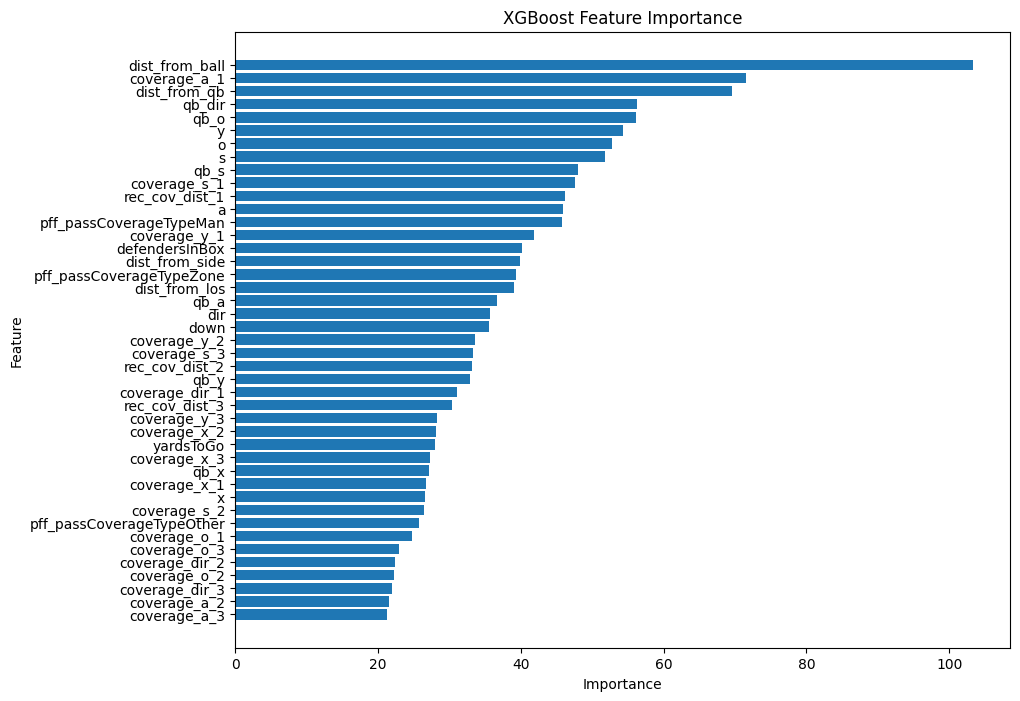

In [ ]:
# Extract feature importance
importance = best_model.get_score(importance_type='gain')

# Convert the feature importance dictionary to a DataFrame
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert predicted probabilities to binary outcomes
train_preds_binary = [1 if x > 0.5 else 0 for x in train_preds]
test_preds_binary = [1 if x > 0.5 else 0 for x in test_preds]

# Accuracy
train_accuracy = accuracy_score(y_train, train_preds_binary)
test_accuracy = accuracy_score(y_test, test_preds_binary)

# Precision, Recall, F1-Score
train_precision = precision_score(y_train, train_preds_binary)
test_precision = precision_score(y_test, test_preds_binary)

train_recall = recall_score(y_train, train_preds_binary)
test_recall = recall_score(y_test, test_preds_binary)

train_f1 = f1_score(y_train, train_preds_binary)
test_f1 = f1_score(y_test, test_preds_binary)

# Confusion Matrix
train_conf_matrix = confusion_matrix(y_train, train_preds_binary)
test_conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Classification Report
test_class_report = classification_report(y_test, test_preds_binary)

# Print all metrics
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

print(f'Train Precision: {train_precision:.4f}')
print(f'Test Precision: {test_precision:.4f}')

print(f'Train Recall: {train_recall:.4f}')
print(f'Test Recall: {test_recall:.4f}')

print(f'Train F1-Score: {train_f1:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

print(f'Test Confusion Matrix:\n{test_conf_matrix}')
print(f'Test Classification Report:\n{test_class_report}')


Train Accuracy: 0.8493
Test Accuracy: 0.8425
Train Precision: 0.8872
Test Precision: 0.7873
Train Recall: 0.0992
Test Recall: 0.0684
Train F1-Score: 0.1785
Test F1-Score: 0.1258
Test Confusion Matrix:
[[314275   1158]
 [ 58406   4286]]
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    315433
         1.0       0.79      0.07      0.13     62692

    accuracy                           0.84    378125
   macro avg       0.82      0.53      0.52    378125
weighted avg       0.83      0.84      0.78    378125



In [ ]:
# If you have binary predictions as well:
train_preds_binary = [1 if x > 0.5 else 0 for x in train_preds]
test_preds_binary = [1 if x > 0.5 else 0 for x in test_preds]

# Convert predictions to DataFrame and make sure they match the index of the original data
train_preds_df = pd.DataFrame({
    'target_prob': train_preds,
    'target_binary': train_preds_binary
}, index=train.index)

test_preds_df = pd.DataFrame({
    'target_prob': test_preds,
    'target_binary': test_preds_binary
}, index=test.index)

In [ ]:
# Join the predictions back to the original data
train_with_preds = train.join(train_preds_df)
test_with_preds = test.join(test_preds_df)

In [ ]:
full_preds = pd.concat([train_with_preds, test_with_preds])

In [ ]:
full_preds[['is_target','gameId','playId','frameId','nflId','target_prob']].head(200)

,is_target,gameId,playId,frameId,nflId,target_prob
0,0.0,2021090900,97.0,1,35481,0.073411
1,0.0,2021090900,97.0,1,35634,0.080309
2,0.0,2021090900,97.0,1,39985,0.081973
3,0.0,2021090900,97.0,1,41233,0.211974
4,1.0,2021090900,97.0,1,44896,0.115511
5,0.0,2021090900,97.0,2,35481,0.067035
6,0.0,2021090900,97.0,2,35634,0.082211
7,0.0,2021090900,97.0,2,39985,0.081276
8,0.0,2021090900,97.0,2,41233,0.224629
9,1.0,2021090900,97.0,2,44896,0.124010


In [ ]:
full_preds.to_parquet("/content/drive/MyDrive/CMSAC_2024/full_target_preds.parquet", index=False)

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
full_preds.describe()

,gameId,playId,nflId,frameId,x,y,dir,s,o,a,coverage_x_1,coverage_x_2,coverage_x_3,coverage_y_1,coverage_y_2,coverage_y_3,coverage_s_1,coverage_s_2,coverage_s_3,coverage_a_1,coverage_a_2,coverage_a_3,coverage_o_1,coverage_o_2,coverage_o_3,coverage_dir_1,coverage_dir_2,coverage_dir_3,rec_cov_dist_1,rec_cov_dist_2,rec_cov_dist_3,qb_x,qb_y,qb_dir,qb_s,qb_o,qb_a,is_target,down,yardsToGo,defendersInBox,week,dist_from_los,dist_from_qb,dist_from_ball,dist_from_side,pff_passCoverageTypeMan,pff_passCoverageTypeOther,pff_passCoverageTypeZone,target_prob,target_binary
count,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00,1663419.00
mean,2021097805.70,2170.80,46212.99,23.38,60.93,26.58,114.07,3.74,124.71,2.30,64.47,65.31,66.32,26.55,26.46,26.31,2.65,2.52,2.52,1.89,1.85,1.81,241.05,247.22,249.23,140.93,143.94,143.82,4.67,8.83,12.39,52.01,26.59,215.88,1.78,121.29,1.71,0.17,1.99,8.81,5.97,4.37,4.66,14.89,14.55,16.58,0.28,0.06,0.66,0.16,0.02
std,4988.16,1221.59,4740.00,16.19,24.36,11.67,76.23,2.72,81.46,1.64,23.84,23.82,23.88,11.53,9.54,8.67,2.15,2.01,2.02,1.44,1.40,1.39,78.55,71.75,69.04,94.62,95.58,95.17,3.05,3.58,4.35,23.73,4.04,91.52,1.78,51.99,1.33,0.37,0.88,3.94,1.00,2.28,5.15,7.97,7.81,5.90,0.45,0.24,0.47,0.11,0.13
min,2021090900.00,54.00,30842.00,1.00,3.24,-2.61,0.00,0.00,0.00,0.00,8.46,8.46,8.46,-0.43,-0.90,-2.47,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.40,0.81,-0.94,-4.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.21,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2021091913.00,1140.00,43010.00,11.00,41.10,17.31,68.27,0.95,77.93,0.96,44.75,45.57,46.68,17.29,18.99,20.78,0.68,0.70,0.73,0.72,0.71,0.70,218.37,229.51,232.95,71.13,72.40,73.44,2.16,6.36,9.34,32.21,23.80,145.01,0.35,88.66,0.63,0.00,1.00,6.00,5.00,2.00,1.24,9.13,8.61,11.95,0.00,0.00,0.00,0.10,0.00
50%,2021100312.00,2172.00,46093.00,22.00,57.97,26.11,97.21,3.97,96.30,2.23,61.36,62.17,63.20,26.21,26.36,26.37,2.36,2.24,2.22,1.69,1.63,1.58,262.56,264.27,264.84,119.77,123.22,121.21,4.08,8.49,11.76,48.51,26.69,260.05,1.32,112.55,1.57,0.00,2.00,10.00,6.00,4.00,2.72,13.75,13.36,17.28,0.00,0.00,1.00,0.15,0.00
75%,2021101710.00,3211.00,48601.00,32.00,79.25,36.05,144.77,6.08,148.35,3.47,82.52,83.31,84.53,35.94,33.93,31.81,4.18,3.91,3.90,2.80,2.72,2.67,286.89,286.67,286.07,188.90,194.73,195.91,6.60,10.80,14.91,69.57,29.74,279.27,2.58,149.80,2.58,0.00,3.00,10.00,7.00,6.00,6.04,20.08,19.64,21.25,1.00,0.00,1.00,0.20,0.00
max,2021110100.00,5223.00,54038.00,203.00,123.55,56.59,360.00,11.18,360.00,18.05,120.02,119.89,119.67,55.47,53.57,54.93,10.39,10.17,10.17,17.11,21.92,21.92,360.00,360.00,360.00,360.00,360.00,360.00,42.79,42.93,52.72,108.16,56.31,360.00,9.78,360.00,13.15,1.00,4.00,39.00,11.00,8.00,53.33,69.51,68.23,26.65,1.00,1.00,1.00,0.98,1.00
